<span style='font-family:"Times New Roman"'> <span style='font-size:20px'>
# <center>Shake Table Analysis Using Machine Learning Example: <br> Deep Neural Network Regression</center>
<br>
<br>
<center>Kayla Erler$^{1}$ and Gilberto Mosqueda$^{1}$<center>
<br>
*<center>$^1$Department of Structural Engineering, University of California, San Diego, CA, U.S.A.<center>*
*<center>$^2$Department of Data Science, University of California, San Diego, CA, U.S.A.<center>*
 <br>
<br>
<strong><center>SUMMARY<center></strong>
<br>
<br>
<div style="text-align: justify">
This series of notebooks entails the investigation of applications of machine learning algorithms for shake table data. The Caltrans Seismic Response Modification Device (SRMD) Testing Facility houses a testing machine used primarily for applying displacement control loading protocols to test seismic isolation bearings. One of the primary outcomes from tests is measurement of the dynamic force response. The testing machine has some inherent horizontal forces due to inertia and machine friction that must be corrected to provide the device force response. The current correction procedure requires a test done with the same signal for the real test with a bare or empty table. The goal of this series of notebooks is to characterize these empty table runs in order to eliminate their need through the use of machine learning. The form of machine learning investigated is known as supervised learning with regression analysis. Linear regression is one of the most simple, straightforward, and commonly used methods available for structural engineers. The implementation of this method was developed in Case 1 of this series. Linear Regression was found to be lacking the detail needed to fully capture the nonlinear dynamic set of equilibrium equations involved in the lubricated and hydrostatic bearing. Friction is known to be a difficult physical phenomenon to properly capture. In this second notebook, a deep neural network (DNN) will be used to approximate the relationship between the inputs and target. DNNs without physics information included in the network architecture are often considered unreliable. For structural engineering applications, there is often much more information that can be provided to the algorithm in order to ensure that the solution is physically possible. This iteration will not take that into consideration, as the formation of a physics informed neural network will be further studied in the subsequent notebook. This notebook, however, does represent a model that may be more flexible for training given any other set of input-output pairs a user may adjust it toward. 
<br>
<br>
Additional challenges exist in the data distribution. Testing data currently available is limited in the application of the vertical load force that the machine is capable of in a real test. In order for vertical load to be applied, there must be a device loaded in the machine. However, if a device is loaded in the machine, the horizontal forces measured are no longer solely inherent forces. With a deep neural network, data within the distribution of training must be provided as there is no equation of the relationship provided for generalization for a different distribution. The Actuator and Outrigger normal forces have thus been removed from the input signals for prediction. Tests were run using the DNN algorithm in which these forces are provided as features. The model was able to achieve a significant increase in accuracy over that seen with the linear regression analysis algorithm. These results are not considered reliable for a real test and therefore have been removed from the protocol. Future work will go towards developing a physics informed neural network that may be able to achieve the desired generalization as well as obtaining testing data with load cells that can indicate the inherent forces when significant differences in the normal force exist.
<br>
<br>


## References and Licensing
This report examines data from the seismic response modification device (SRMD) empty table runs. More details on the testing facility can be found at the following link:
> • [Caltrans Seismic Response Modification Device (SRMD) Test Facility](https://se.ucsd.edu/facilities/laboratory-listing/srmd)

The data published in DesignSafe and can be found in the link below:
> • [TBD] currently included in this directory

Refferences for the papers used to facilitate developement of the models in this project can be found at the following links:
> • [Shortreed et al. (2001)](https://royalsocietypublishing.org/doi/10.1098/rsta.2001.0875) "Characterization and testing of the Caltrans Seismic Response Modification Device Test System". Phil. Trans. R. Soc. A.359: 1829–1850
<br>
> • [Ozcelick et al. (2008)](http://jaguar.ucsd.edu/publications/refereed_journals/Ozcelik_Luco_Conte_Trombetti_Restrepo_EESD_2008.pdf) "Experimental Characterization, modeling and identification of the NEES-UCSD shake table mechanical systetm". Eathquake Engineering and Structural Dynamics, vol. 37, pp. 243-264, 2008



Citation and Licensing:
> •	[Erler et al. (2024)]() "Leveraging Machine Learning Algorithms for Regression Analysis in Shake Table Data Processing". WCEE2024
<br>
> •	[Rathje et al. (2017)](https://doi.org/10.1061/(ASCE)NH.1527-6996.0000246) "DesignSafe: New Cyberinfrastructure for Natural Hazards Engineering". ASCE: Natural Hazards Review / Volume 18 Issue 3 - August 2017
<br>
> •	This software is distributed under the [GNU General Public License](https://www.gnu.org/licenses/gpl-3.0.html).

## Prior Knowledge and Resources
This notebook is intended for users with some level of experience with python coding and a basic understanding of machine learning. Resources for these underlying principles are as follows:

1. [Introduction to Scientific Programming with Python](https://www.youtube.com/watch?v=ivZH9JUwvrc)

2. [An Example-Based Introduction to Common Machine Learning Approaches](https://www.designsafe-ci.org/rw/use-cases/#!#vantassel_and_zhang%2Fusecase%2F)

3. [Workshop on Artificial Intelligence in Natural Hazards Engineering](https://www.designsafe-ci.org/data/browser/public/designsafe.storage.published/PRJ-2767)

## Table of Contents
* [1. Introduction](#first-bullet)
* [2. Load and Install Python Libraries](#second-bullet)
* [3. Preprocess Data](#third-bullet)
* [4. Deep Neural Network](#fourth-bullet)
    * [4.1 Individual Hyperparameter Selection](#fourth1-bullet)
    * [4.2 Grid Search Hyperparameter Tuning](#fourth2-bullet)
    * [4.3 Pre-trained Network Loading](#fourth2-bullet)
* [5. Result Visualization](#fifth-bullet)
* [6. Conclusion](#sixth-bullet)

## 1. Introduction  <a class="anchor" id="first-bullet">
<div style="text-align: justify">
        This notebook emphasizes the development of a deep neural network (DNN) using a PyTorch implementation. A grid search is written to allow for automated hyperparameter tuning. The selection below allows the user to control which type of test they would like to conduct. By default, a pre-trained model is executed to allow interaction with the post-processing tools without the need to wait for training time. All training notebooks automatically save the trained model with hyperparameters to the resutlts folder. If this notebook is used directly in the published directory some functionality is decreased as the user will not have writing permission. <br><br> If this notebook is moved to a writing permission directory, the user is able to perform a streamlined set of experiments starting from a configurable .yaml file. These are storred in the DNNconfigs folder. To create a new experiment, make a copy of an existing configuration, modify the desired hyperparamers, change the name of the file to reflect the new version number, and input that version number in the following code cell for the variable 'model_version'. Once this is done, the user will be able to perform the training either using notebook mode 1 for a single set of hyperparameters or notebook mode 2 to use a randomized grid search to select a 'best' set of hyperparameters. The results including the normalization parameters used on data before training, a copy of the hyperparameter configurations, and the model itself will be outputted to the results folder with the model version number. Additionally, a csv file with the testing scores over each hyperparameter tested will be stored so that the user can inspect for trends in hyperparameter tuning. <br><br> If writing permission is disabled, a set of pre-trained models and experiments exists that the user can extract from. Ensure that a model version exists that corresponds to the model_version variable if you would like to try out a different model then the default.  Additional tests can be performed by modifying the hyperparameters in this notebook with the corresponding section. For this to be possible, set the variable 'load_hyper_from_file' to False. The results will not be saved as long as the 'save_results' flag is set to False.  

In [16]:
######### Select Desired Notebook Mode ####################
# 1 for training with inputted hyperparameters
# 2 for training with grid search selected hyperparameters
# 3 for loading pre-trained model and exploring post-processing features alone
notebook_mode = 1

# Modify the following variables to change the primary functions of the notebook
model_version = 1            # use to load a specific model version for mode 3 or to train a new model version for mode 1 or 2
load_hypers_from_file = True # set to true to use the hyper_path or hyper_grid_path for modes 1 or 2, respectively
save_results = True          # set to False if in read only mode on DesignSafe 

# below parameters are default and should not need to be altered
model_type = 'DNN'           # enter the model type
current_model_name = "modelv" + str(model_version)  # enter model name
results_folder = model_type + 'Results'             # enter the path to the results folder
config_folder  = model_type + 'configs'             # enter the path to the config folder
path_names = {'results': results_folder,
              'new_hypers': config_folder + '/' + current_model_name + '.yaml',
              'hyper_grid': config_folder + '/hyper_tuning_v' + str(model_version) + '.yaml',
              'saved_hypers': results_folder + '/' + current_model_name + '_config.yaml',
              'saved_model': results_folder + '/' + current_model_name,
              'norm_params': results_folder + '/' + current_model_name + '_norm_params.npy',
              'grid_results': results_folder + '/' + current_model_name + '_hyper_grid.csv',
              'data': 'preprocessed_data',
              'save_results': save_results}

## 2. Load and Install Python Libraries <a class="anchor" id="second-bullet">
If running this code on the DesignSafe platform, the python libraries listed below need to be installed on the initial run with the currently activated server or every three days for the DesignSafe platform's updated image (do not run on the classic image). Otherwise, all neccesary installations can be performed with the requirements.txt file.

In [17]:
!pip install --quiet scikit-learn
!pip3 install --quiet torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

The python libraries used in the primary code for the notebook are shown below.

In [18]:
# python files created for this project
import preprocess_data
import post_process
import DNN_functions

# Open source libraries available in python
import yaml
import numpy as np

#in case underlying files need updating while the notebook is running
import importlib

## 3. Preprocess Data <a class="anchor" id="third-bullet">
<br>
<div style="text-align: justify">
     "Case 0. PreprocessingVisualization.ipynb" included with this project shows the underlying filter functions that are implemented here. All data is passed through the signal processing algorithm and converted to a dictionary with the 87 indexes corresponding to the 87 test runs that were available in the ET_Runs folder. If this process has been completed previously, the signals dictionary will be saved to a pickle file in the preprocessed_data folder (or any other name inputted as the first variable of the function below). 

In [19]:
# load data set from individual testing files or with preprocessed data
signals_dictionary = preprocess_data.load_data_set(path_names['data'], path_names['save_results']) 
features = DNN_functions.create_feature_dictionary(signals_dictionary, path_names)   

Loading Stored Data


## 4. Fit Deep Neural Network <a class="anchor" id="fourth-bullet">
<div style="text-align: justify">
    A deep neural network can take on many forms but at its base consists of layers of neurons connecting the inputted features to the targetted prediction. These layers and the activation functions are used to approximate nonlinear functions using linear combinations that are differentiable. The purpose of linear combinations with differentiable activation functions is that it allows for updates to be propogated between the final layer loss function and previous layer weights known as back propogation. A pytorch model is used to form a mini-batch gradient descent algorithm in this notebook. Points in time for the model are considered discrete. No sequence order is neccesary as the algorithm will use one set of input-targets at a time to train with.

### 4.1 Individual Hyperparameter Selection <a class="anchor" id="fourth1-bullet">
This section of code implements the first of three notebook modes. The training of a model with specific hyperparameters can be performed by either writing in the desired hyperparameters if the variable load_hypers_from_file is False or the selected path can be accessible to load the coonfigurable file for hyperparameter selection. The benefit of using the configuration file for hyperparameter selection is the ability to save these configuration files to keep track of experiments. For additional book keeping, the hyperparameters for training are saved to a configuration file in the results folder as well. These will be needed for use in iniating the model for later prediction. 
<br>
Training will be performed using GPU if available, otherwise, the model runs on CPU. The hyperparameters selected for tuning, do not span the potential hyperparameters that could be used for model improvement; however, they have been found to provide sufficient variability for the purposes of the model. The hyperparameters selected for inspection in this training process are:

- hidden_neurons: number of neurons in a hidden layer of the network
- hidden_layers:  number of hidden layers between the input and output layer of the neural network
- activation:     nonlinear function used after the linear combination at neural network hidden layers tanh and sigmoid are common choices for classification, while relu and leaky relu are common choices for regresion analysis
- learning_rate:  rate that determines the step size at which the model's parameters are updated during training
- num_epochs: number of epochs to run the mini-batch training algorithm over
- dropout_prob: percentage of neurons that are randomly "dropped out" for neurons in the hidden layers. A regularization technique that helps to prevent overfitting.


Loading hyperparameters from file: DNNconfigs/modelv1.yaml
Running on: cpu


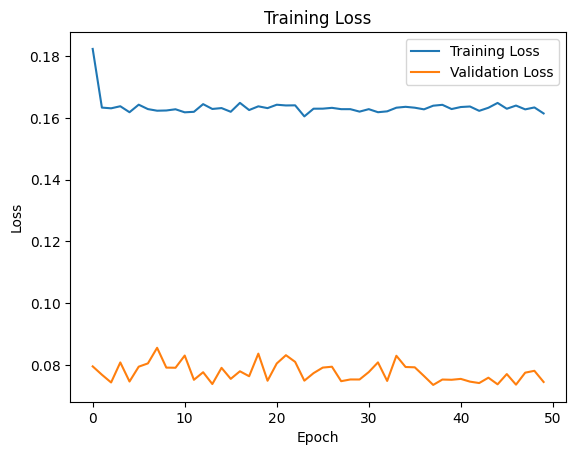

Layer (type:depth-idx)                   Param #
DeepNeuralNetwork                        --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       10
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       3
Total params: 13
Trainable params: 13
Non-trainable params: 0
R-squared value (train): 0.9250767673161339
R-squared value (test): 0.9244398966372627
Finished Training


In [20]:
importlib.reload(DNN_functions)
if notebook_mode == 1:
    if load_hypers_from_file:
        print('Loading hyperparameters from file: ' + path_names['new_hypers'])
        hyperparameters = yaml.load(open(path_names['new_hypers'], 'r'), Loader=yaml.SafeLoader)
    else:
        print('Using mannually inputed hyperparameters')
        hyperparameters = {
            'hidden_neurons': 2,
            'hidden_layers': 1,
            'activation': 'relu',
            'learning_rate': 0.01,
            'batch_size': 512,
            'num_epochs': 2,
            'dropout_prob': 0.1
        }
    # Train and test the model
    model, r2_train, r2_val, r2_test = DNN_functions.train_model(features, hyperparameters, path_names)

### 4.2 Gridsearch Hyperparameter Tuning <a class="anchor" id="fourth2-bullet">
It is well known that the selection of the best hyperparameters is not a straight forward process as different sets will work better for different problems wihtout a general trend between datasets. To address hyperparameter selection, the second notebook mode implements a randomized hyperparameter grid search. The user can control the percentage of total combinations to be inspected. Note this process could take hours to multiple days dependent on the complexity of the grid and number of epochs being tested. The grid search trains and tests each parameter combination randomly selected from the total grid. The hyperparameters and their test scores are then saved to a csv file in order for the user to gain more insight on the fluctuation of results within a general region of the grid. Using a broad sparse grid to start and finding model trends then zooming in to regions that provided good results is a good way to attain the desired parameters. More complex algorithms have been developed for hyperparameter selection optimization but for simplicity this commonly used approach is provided. As with notebook mode 1, the user is able to specify the grid search in either a configurable file or in the following code block. 

In [21]:
if notebook_mode == 2:
    if load_hypers_from_file:
        print('Loading hyperparameters from file: ' + path_names['hyper_grid'])
        param_grid = yaml.load(open(path_names['hyper_grid'], 'r'), Loader=yaml.SafeLoader)
    else:
        print('Using mannually inputed hyperparameter grid')
        param_grid = {
            'hidden_neurons': [2],
            'hidden_layers': [1],
            'activation': ['relu','leaky_relu'],
            'learning_rate': [0.0001],
            'batch_size': [500],
            'num_epochs': [2],
            'dropout_prob': [0.2]
        }
    model = DNN_functions.random_search(param_grid, signals_dictionary, path_names, search_space_ratio = 0.8)

### 4.3 Pre-Trained Network Loading <a class="anchor" id="fourth3-bullet">
The final mode possible for this notebook is loading a pre-trained model. It is neccesary to have the hyperparameter configuration file corresponding to the trained model loaded in order to initialize the network. Once the model has been loaded, the user can predict on any given dataset that matches the number of features provided in the initial model. The interactive plots in the next section will be viewable to see model trends. 

In [22]:
if notebook_mode == 3:
    model = DNN_functions.initiate_saved_model(path_names['saved_hypers'], path_names['saved_model'], signals_dictionary[0]['data'])

## 5. Result Visualization <a class="anchor" id="fifth-bullet">
To get a better idea of model fit, individual runs are plotted. Datasets are normalized on a per run basis for calculation of the MSE in order to have a fair comparison of results between data sets with unequal amplitudes. The acceleration and velocity amplitudes for each run are normalized over the datasets for insight into the affect of larger and smaller amplitude on the prediction accuracy. 

Loading Stored Data


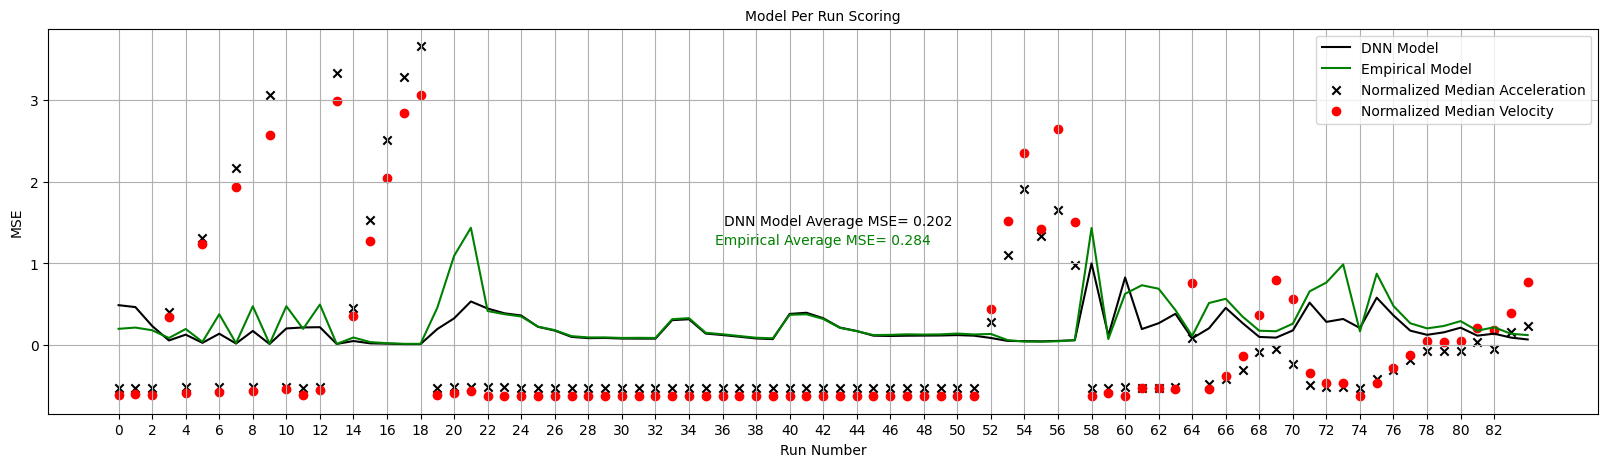

In [23]:
norm_params = np.load(path_names['norm_params'], allow_pickle = True)
empirical_output, model_output = post_process.test_scores(
    model = model,
    model_type = model_type, 
    norm_params = norm_params)
post_process.model_per_run_scoring(empirical_output, model_output, model_name = model_type + " Model")

Loading Stored Data


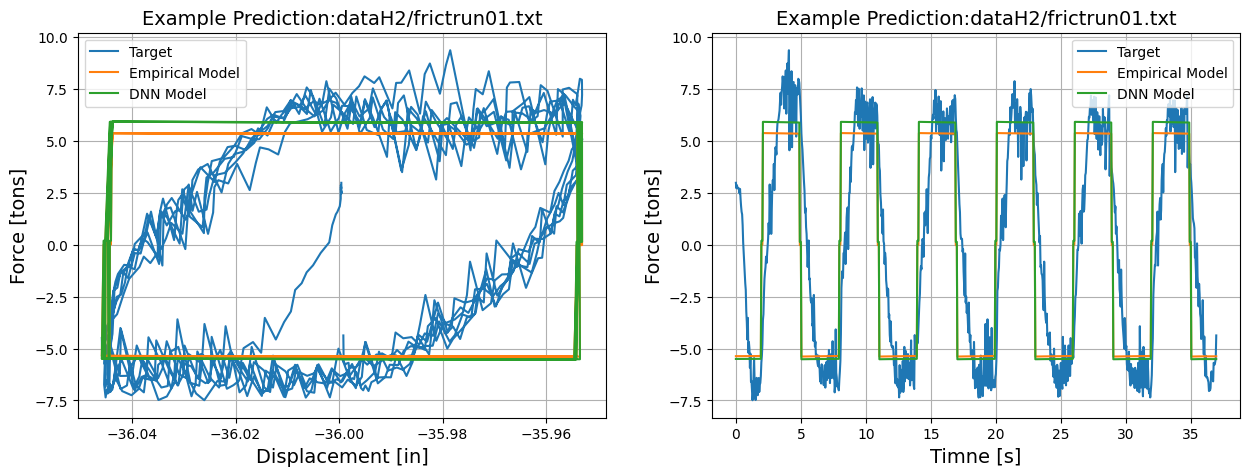

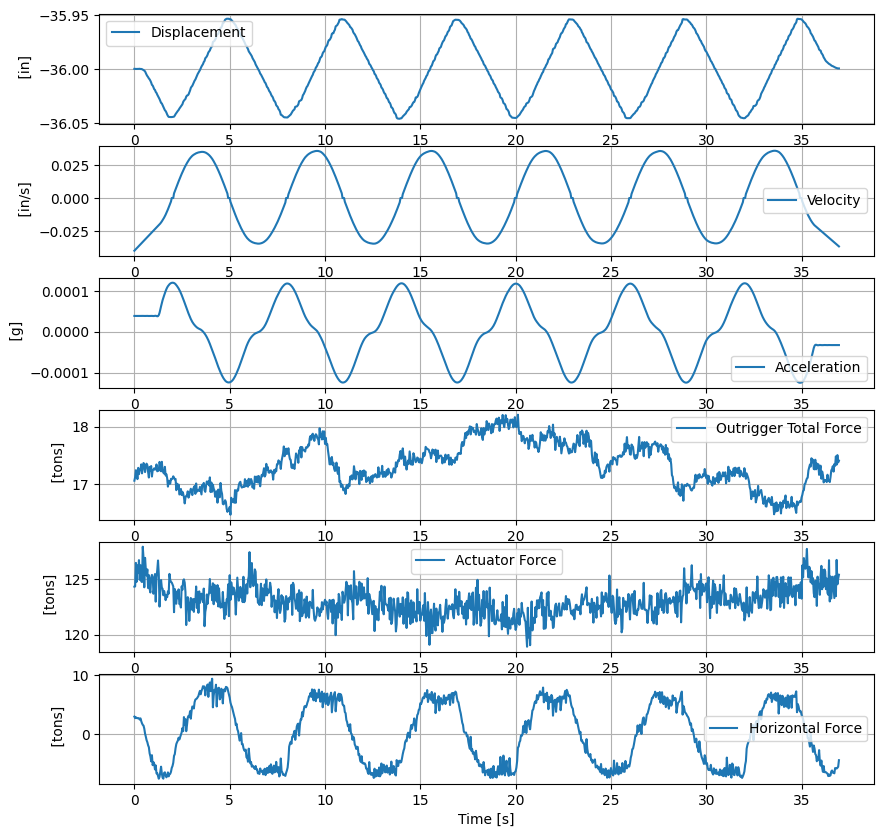

In [24]:
# target and prediction plot
test = 22
importlib.reload(post_process)
post_process.plot_prediction(empirical_prediction = empirical_output[test]['prediction'], 
                             model_prediction = model_output[test]['prediction'],
                            signals = signals_dictionary[test]['data'],
                            model_name = model_type + ' Model',
                            run_name = signals_dictionary[test]['test'])
post_process.plot_signals(test)

## 6. Conclusions <a class="anchor" id="sixth-bullet">
The research findings reveal intriguing variations in output across different experiments, despite similar model accuracy that can be most easily noted in the hysteresis prediction plots. The consistency in scores between testing and training datasets suggests that overfitting is not the primary cause of these disparities, as overfitting tends to produce highly erratic outputs. While the deep neural network exhibits superior accuracy compared to both linear regression and empirical models, the reliability of this improvement appears to be inconsistent. Since the dataset was consistently randomized across testing and training sets in all runs, it is reasonable to assume a uniform underlying distribution.

To enhance the model's generalization capabilities, it is imperative to conduct test runs that lie outside the training set's distribution. Experiments in this direction yielded results with notably varying accuracy. A promising avenue for bolstering model reliability involves the implementation of a physics-informed neural network. By incorporating information about physical constraints into the architecture and loss function, this approach empowers the model to generalize effectively and perform admirably on test sets that may deviate from the trained distribution.

Further investigations may explore the utilization of a pretrained network in conjunction with synthesized data. This strategy aims to mitigate the impact of noise on the model's output, without potentially compromising crucial information through filtering.